In [2]:
import sys, os
helper_py_location = os.path.abspath(os.path.join(os.path.join(os.getcwd(), "../..") ,"src","helper"))
print(helper_py_location)
sys.path.append(helper_py_location)

e:\zhaoj\download\workSpace\Portfolio_Management\src\helper


In [3]:
import helper
HF_returns_original = helper.load_data('HW_Hedge_Fund.xlsx',1)
M_ER_country_original = helper.load_data('HW_World.xlsx')
Emp_factors_original = helper.load_data('HW_Factors.xlsx')
HP_DJ_Sto_original = helper.load_data('HW_DJIA_Prices.xlsx',4)

HP_DJ_Sto_Ind_ori = helper.load_data('HW_DJIA_Prices.xlsx')
HP_DJ_Sto_Ind = HP_DJ_Sto_Ind_ori.copy()


#clean
HF_returns =HF_returns_original.copy()
Emp_factors = Emp_factors_original.copy()
M_ER_country = M_ER_country_original.copy()
HP_DJ_Sto = HP_DJ_Sto_original.copy()

Emp_factors.iloc[:, 1:] = Emp_factors.iloc[:, 1:].div(100)
M_ER_country.iloc[:,1:] = M_ER_country.iloc[:,1:].div(100)
Emp_factors.rename(columns={Emp_factors.keys()[0]: 'Date'}, inplace=True)

### Part 3 Portfolio Construction
* famlize the Dow Jones
* famlize diff weighting methodologies

1. Different Portfolios - weights

In [4]:
print(type(HP_DJ_Sto))
HP_DJ_Sto.head()

<class 'pandas.core.frame.DataFrame'>


,Date,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,...,NKE,PG,CRM,BAC,UNH,VZ,HWP,PFE,WMT,DJIA
0,2004-06-30,90.01,51.38,54.57,49.0842,51.09,79.44,94.11,23.70,50.48,...,75.75,54.44,16.07,84.62,62.25,36.19,21.10,34.28,52.76,10139.71
1,2004-07-30,82.36,50.25,56.88,52.3474,50.75,73.49,95.65,20.92,43.86,...,72.71,52.15,13.01,85.01,62.90,38.54,20.15,31.96,53.01,10173.92
2,2004-08-31,82.36,50.02,59.29,58.8130,52.22,72.70,97.50,18.76,44.71,...,75.31,55.97,13.00,44.98,66.13,39.25,17.89,32.67,52.67,10080.27
3,2004-09-30,79.97,51.46,56.81,79.5303,51.62,80.45,53.64,18.10,40.05,...,78.80,54.12,15.63,43.33,73.74,39.38,18.75,30.60,53.20,10027.47
4,2004-10-29,77.57,53.07,56.80,101.7654,49.90,80.54,53.06,19.21,40.66,...,81.31,51.18,20.32,44.79,72.40,39.10,18.66,28.95,53.92,10428.02


# the cell below will change the period to BT and we see the same process of another one

In [6]:
import pandas as pd
RF = 0.02
HP_DJ_Sto_Ind = HP_DJ_Sto_Ind_ori.copy()
HP_DJ_Sto_Ind = HP_DJ_Sto_Ind[4:]
HP_DJ_Sto_Ind.columns = HP_DJ_Sto_Ind.columns[:-1].tolist() + ['DJIA']
HP_DJ_Sto_Ind.columns =  ['Date'] +  HP_DJ_Sto_Ind.columns[1:].tolist()
Backtesting_Period = HP_DJ_Sto_Ind[HP_DJ_Sto_Ind['Date'] <= pd.to_datetime('2019-01-01')]
Test_period = HP_DJ_Sto_Ind[HP_DJ_Sto_Ind['Date'] > pd.to_datetime('2019-01-01')]

In [12]:
# Backtesting_Period.iloc[1,:]
# HP_DJ_Sto

Build diff weight stragy

In [13]:
import pandas as pd
import numpy as np
Portfolio = []
intern = []
# new_weight = pd.DataFrame()
HP_DJ_Sto = Backtesting_Period
number_of_stock = HP_DJ_Sto.iloc[0,1:-1].shape[0]
price_only = HP_DJ_Sto.iloc[:,1:-1]
start_Price = HP_DJ_Sto.iloc[0,1:-1]
start_shares = HP_DJ_Sto_Ind_ori.iloc[1,1:-1]
returns = price_only.pct_change()
#value
mkt_Cap =  np.array(start_Price)*np.array(start_shares)
total_Cap = np.sum(mkt_Cap)
for i in range(number_of_stock):
    intern.append(mkt_Cap[i]/total_Cap)
Portfolio.append(intern) 

#equal_weight
intern = [1/number_of_stock for _ in range(number_of_stock)]
Portfolio.append(intern) 

#min_var
cov_matrix = returns.cov()
one = np.ones(cov_matrix.shape[1])
Inv_cov = np.linalg.inv(cov_matrix)

# min_var_weights = Inv_cov.dot(one) / np.dot(one.T, Inv_cov.dot(one))
min_var_weights = np.dot(Inv_cov, one) / \
                  np.dot(one.T, Inv_cov.dot(one))
# print(min_var_portfolio)
Portfolio.append(min_var_weights.tolist())

'''  min_var_weights = Inv_cov@one/np.sum(Inv_cov@one)
Portfolio.append(min_var_weights.tolist())  '''

#naive risk parity
vol = price_only.pct_change().std()*np.sqrt(12)
inverse_vol = 1 / vol
normalized_I_vol = [x / sum(inverse_vol) for x in inverse_vol]
Portfolio.append(normalized_I_vol)

#Tangent --- ost Diversified Portfolio
RF = 0.02
ret_matix = returns.mean()*12 - RF
tangent_weight = np.dot(Inv_cov,ret_matix)/ \
                np.dot(one.T,Inv_cov.dot(ret_matix))
Portfolio.append(tangent_weight)


# display(weight)


C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\2527411625.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  returns = price_only.pct_change()
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\2527411625.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vol = price_only.pct_change().std()*np.sqrt(12)


In [457]:
# #buy largest
# industries = HP_DJ_Sto_Ind.iloc[0,1:-1]
# # Drop the first row to retain only stock prices
# # mkt_Cap =  np.array(start_Price)*np.array(start_shares)
# # total_Cap = np.sum(mkt_Cap)

# mkt_cap_ind = pd.DataFrame(mkt_Cap, index=HP_DJ_Sto_Ind.columns[1:-1], columns=['mkt_cap'])
# largest_stocks = mkt_cap_ind.groupby(industries, axis=0).idxmax()
# largest_stocks.values
# largest_stocks.shape

In [14]:
#buy largest
industries = HP_DJ_Sto_Ind.iloc[0,1:-1]
# Drop the first row to retain only stock prices
# mkt_Cap =  np.array(start_Price)*np.array(start_shares)
# total_Cap = np.sum(mkt_Cap)

mkt_cap_ind = pd.DataFrame(mkt_Cap, index=HP_DJ_Sto_Ind.columns[1:-1], columns=['mkt_cap'])
largest_stocks = mkt_cap_ind.groupby(industries, axis=0).idxmax()
# largest_stocks = HP_DJ_Sto_Ind.groupby(industries, axis=1).idxmax(axis = 1)
weight_of_buylarge = 1/largest_stocks.shape[0]
largest_stocks_weights=[]

for stock in HP_DJ_Sto_Ind_ori.iloc[:,1:-1].columns:
    if stock in largest_stocks.values:
        largest_stocks_weights.append(weight_of_buylarge)
    else:
            largest_stocks_weights.append(0)
Portfolio.append(largest_stocks_weights)

C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\2772243726.py:8: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  largest_stocks = mkt_cap_ind.groupby(industries, axis=0).idxmax()


In [15]:
#idustry_equal
HP_DJ_Sto_Ind = HP_DJ_Sto_Ind_ori.copy()
industries = HP_DJ_Sto_Ind.iloc[0,1:-1]
# HP_DJ_Sto_Ind = HP_DJ_Sto_Ind.iloc[1]

number_ind = HP_DJ_Sto_Ind.groupby(industries, axis=1).count().iloc[0]
equal_weights = number_ind.loc[HP_DJ_Sto_Ind_ori.iloc[0,1:-1]].apply(lambda x:1/x*0.2).values
Portfolio.append(equal_weights)

C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\1025226775.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  number_ind = HP_DJ_Sto_Ind.groupby(industries, axis=1).count().iloc[0]


In [16]:
# len(Portfolio[4])
weight = pd.DataFrame(Portfolio,
                      index = ['value','equal_weight','min_var','naive','tangent','large5','idustry_equal'], 
                      columns = HP_DJ_Sto.columns[1:-1])
                    #   ,index = ['value','equal_weight','min_var','naive','tangent','large5','idustry_equal'], columns = HP_DJ_Sto.columns[1:])

weight.T

,value,equal_weight,min_var,naive,tangent,large5,idustry_equal
3M CO,0.022431,0.033333,0.101386,0.040296,0.189792,0.033333,0.020000
AMERICAN EXPRESS CO,0.020921,0.033333,-0.015823,0.022888,-0.118538,0.033333,0.050000
AMGEN INC,0.022003,0.033333,-0.014486,0.031232,0.111950,0.033333,0.020000
APPLE COMPUTER INC,0.060244,0.033333,0.066610,0.022706,0.359748,0.033333,0.028571
BOEING CO,0.013725,0.033333,0.067267,0.030638,0.300033,0.033333,0.050000
CATERPILLAR INC,0.008654,0.033333,0.005082,0.022765,0.106091,0.033333,0.020000
CHEVRON CORP NEW,0.032087,0.033333,0.045067,0.032908,0.046018,0.033333,0.050000
CISCO SYSTEMS INC,0.051060,0.033333,-0.020498,0.029971,0.033784,0.033333,0.028571
COCA COLA CO,0.039177,0.033333,0.004200,0.037071,-0.119259,0.033333,0.020000
DISNEY WALT CO,0.016668,0.033333,0.011437,0.036850,0.365083,0.033333,0.040000


### 2. Compare Portfolios

In [461]:
# HP_DJ_Sto.loc[:,'Date'] === HP_DJ_Sto['Date']

In [17]:
display(HP_DJ_Sto.iloc[:,-1])

4      10139.71
5      10173.92
6      10080.27
7      10027.47
8      10428.02
         ...   
174    26458.31
175    25115.76
176    25538.46
177    23327.46
178    24999.67
Name: DJIA, Length: 175, dtype: object

e:\zhaoj\download\workSpace\.venv\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


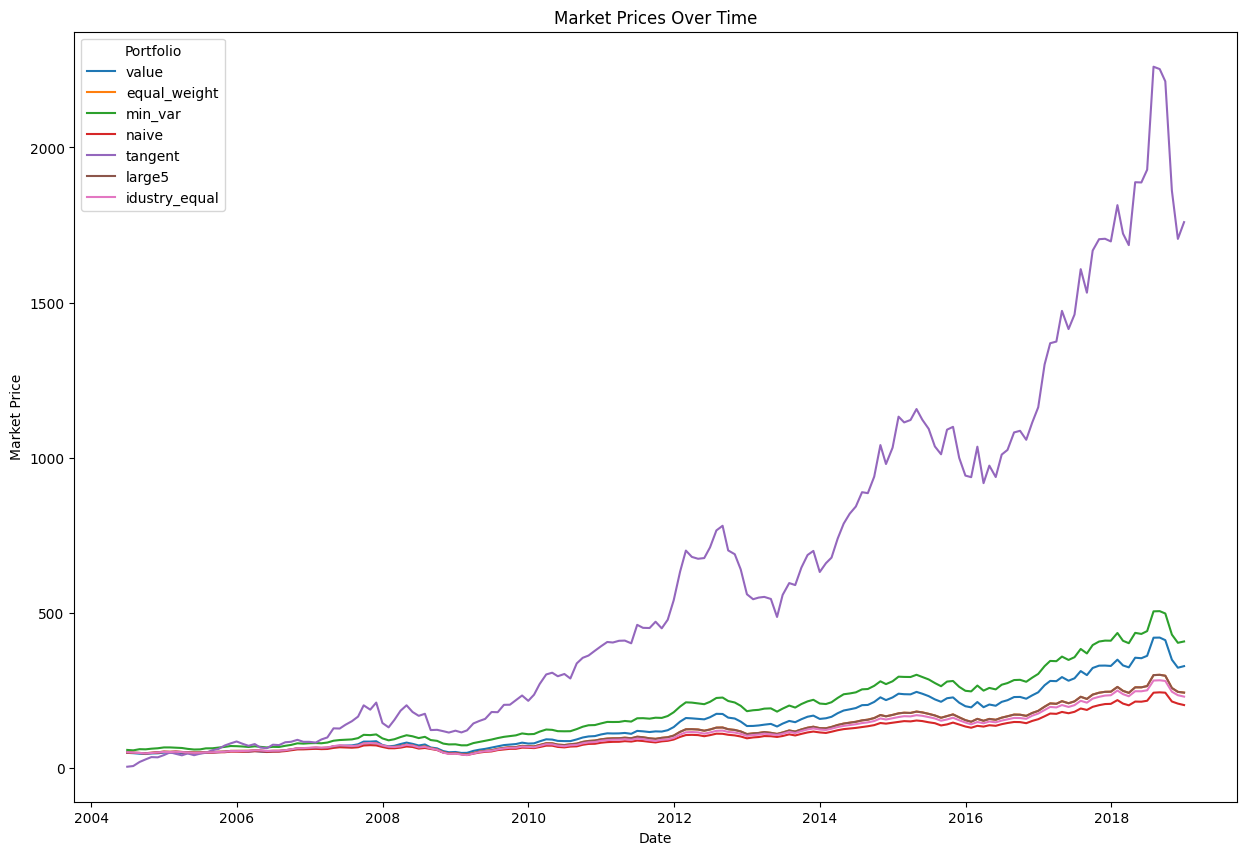

In [18]:
import matplotlib.pyplot as plt
output_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'output')

HP_DJ_Sto.shape # 223x32
weight.shape # 7* 30
market_prices = np.dot(weight,HP_DJ_Sto.iloc[:,1:-1].T)
# pd.DataFrame(market_prices).shape
mkt_P_df = pd.DataFrame(market_prices, index=weight.index, columns=HP_DJ_Sto['Date'])
mkt_P_bench_df = HP_DJ_Sto.iloc[:,-1].T
plt.figure(figsize=(15, 10))
for stock in mkt_P_df.index:
    plt.plot(mkt_P_df.columns, mkt_P_df.loc[stock,:], label=stock)

plt.title('Market Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Market Price')
plt.legend(title='Portfolio')
plt.savefig(os.path.join(output_folder,'Market_Prices_Over_Time.png'))
plt.show()




### 3.Performance Measures

In [21]:
def Month_to_annu_return(price_list:pd.DataFrame):
    list_intern = []
    for i in range(0, price_list.shape[0]-12, 12):
        xx = price_list.iloc[i+11].values/price_list.iloc[i].values - 1
        list_intern.append(xx)
    return list_intern

def calculate_average_annualized_return(price_list: pd.DataFrame):
    """
    Calculate the average annualized return for each stock in the given DataFrame.

    Parameters:
    price_list (pd.DataFrame): DataFrame containing the stock prices.

    Returns:
    list: List containing the average annualized return for each stock.
    """
    # annu_return = Month_to_annu_return(price_list)
    # average_annu = np.mean(np.array(annu_return), axis=0).tolist()
    annu_return = np.mean(price_list.pct_change(),axis=0)*12
    average_annu = annu_return.tolist()
    # average_annu = annu_return.to_frame()
    return average_annu

def volatility(sto_price: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the volatility of the returns for each stock in the given DataFrame.

    Parameters:
    sto_price (pd.DataFrame): DataFrame containing the stock prices.

    Returns:
    pd.DataFrame: DataFrame containing the volatility of the returns for each stock.
    """
    # Calculate the daily returns
    daily_returns = sto_price.pct_change()
    
    # Calculate the volatility (standard deviation of daily returns)
    volatility = daily_returns.std() * np.sqrt(12)  # Assuming 252 trading days in a year
    
    return volatility

def skewness(sto_price: pd.DataFrame):
    daily_returns = sto_price.pct_change()
    skewness_values = daily_returns.skew()
    return skewness_values


def max_drawdown(sto_price: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the maximum drawdown for each stock in the given DataFrame.

    Parameters:
    sto_price (pd.DataFrame): DataFrame containing the stock prices.

    Returns:
    pd.DataFrame: DataFrame containing the maximum drawdown for each stock.
    """
    # Calculate the cumulative returns
    cumulative_returns = (sto_price.pct_change() + 1).cumprod()
    
    # Calculate the peak
    peak = cumulative_returns.expanding(min_periods=1).max()

    # Calculate the drawdown
    drawdown = (cumulative_returns - peak) / peak
    
    # Calculate the maximum drawdown
    max_drawdown = drawdown.min()
    
    max_drawdown = max_drawdown.abs()
    return max_drawdown

def sharpe_ratio(sto_price: pd.DataFrame, RF :float):
    """
    Calculate the Sharpe Ratio for each stock in the given DataFrame.

    Parameters:
    sto_price (pd.DataFrame): DataFrame containing the monthly prices of each stock.
    RF (float): Risk-free rate.

    Returns:
    pd.DataFrame: DataFrame containing the Sharpe Ratio for each stock.
    """
    # Calculate the monthly returns
    monthly_returns = sto_price.pct_change()
    
    # Calculate the average monthly return
    avg_monthly_return = monthly_returns.mean() * 12
    
    # Calculate the standard deviation of monthly returns
    std_dev_monthly_return = monthly_returns.std() * np.sqrt(12)
    
    # Calculate the Sharpe Ratio
    sharpe_ratio = (avg_monthly_return - RF) / std_dev_monthly_return
    
    return sharpe_ratio

def calculate_portfolio_metrics(HP_DJ_Sto_Ind, RF):
    intern_list = []
    HP_DJ_Sto = HP_DJ_Sto_Ind.iloc[:,1:] #Data without date
    Date = HP_DJ_Sto_Ind.iloc[:,1] #Only Date

    average_annu = calculate_average_annualized_return(HP_DJ_Sto)
    intern_list.append(average_annu)
    
    volatility_values = volatility(HP_DJ_Sto).values.tolist()
    intern_list.append(volatility_values)
    
    skewness_values = skewness(HP_DJ_Sto).values.tolist()
    intern_list.append(skewness_values)
    
    max_drawdown_values = max_drawdown(HP_DJ_Sto).values.tolist()
    intern_list.append(max_drawdown_values)
    
    sharpe_ratio_values = sharpe_ratio(HP_DJ_Sto,RF).values.tolist()
    intern_list.append(sharpe_ratio_values)
    
    return intern_list

In [25]:
Risk_free = 0.02
BT_performance = calculate_portfolio_metrics(Backtesting_Period,Risk_free)
BT_perform_df = pd.DataFrame(BT_performance,
                  index = ['Annu_return', 'Volatility','Skewness','Maximum drawdown','Sharpe Ratio'],
                   columns=HP_DJ_Sto.columns[1:])
# BT_perform_df


C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\4246926023.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annu_return = np.mean(price_list.pct_change(),axis=0)*12
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\4246926023.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_returns = sto_price.pct_change()
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\4246926023.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) inste

#### Test our strategy

In [32]:
Risk_free =0.02
Test_perform = calculate_portfolio_metrics(Test_period,Risk_free)
test_perform_df = pd.DataFrame(Test_perform,
                  index = ['Annu_return', 'Volatility','Skewness','Maximum drawdown','Sharpe Ratio'],
                   columns=HP_DJ_Sto.columns[1:])
display(test_perform_df)
# display(Test_perform)
# .loc[:,Aggre_stock,Conser_stock]


C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\4246926023.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annu_return = np.mean(price_list.pct_change(),axis=0)*12
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\4246926023.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_returns = sto_price.pct_change()
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_40568\4246926023.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) inste

,3M CO,AMERICAN EXPRESS CO,AMGEN INC,APPLE COMPUTER INC,BOEING CO,CATERPILLAR INC,CHEVRON CORP NEW,CISCO SYSTEMS INC,COCA COLA CO,DISNEY WALT CO,...,NIKE INC,PROCTER & GAMBLE CO,SALESFORCE COM INC,BANK OF AMERICA CORP,UNITED HEALTHCARE CORP,VERIZON COMMUNICATIONS INC,HEWLETT PACKARD CO,PFIZER INC,WAL MART STORES INC,DJIA
Annu_return,-0.101650,0.139423,0.118527,0.370834,-0.048367,0.198822,0.175122,0.040646,0.091066,-0.001035,...,0.138573,0.130332,0.022245,0.094979,0.199748,-0.072157,0.107634,0.085041,0.118971,0.088493
Volatility,0.239608,0.306934,0.257691,0.322972,0.505569,0.318875,0.356412,0.282676,0.197360,0.360518,...,0.309252,0.172974,0.349800,0.335014,0.237099,0.162009,0.341754,0.278285,0.193677,0.193495
Skewness,-0.108169,0.041249,0.486715,-0.134556,0.202161,0.582553,0.522503,0.230384,-0.906845,0.422612,...,-0.158844,0.198551,1.078603,-0.342723,0.671002,-0.081028,0.078853,0.533947,-0.420687,-0.093070
Maximum drawdown,0.468188,0.340802,0.217501,0.264042,0.724793,0.319396,0.441498,0.368786,0.242295,0.540415,...,0.508863,0.228206,0.557576,0.397217,0.151711,0.391368,0.358393,0.258933,0.205308,0.232013
Sharpe Ratio,-0.507706,0.389083,0.382346,1.086267,-0.135227,0.560790,0.435233,0.073038,0.360085,-0.058347,...,0.383417,0.637850,0.006418,0.223809,0.758114,-0.568840,0.256424,0.233720,0.511012,0.353980


In [31]:
# Test_period

e:\zhaoj\download\workSpace\.venv\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


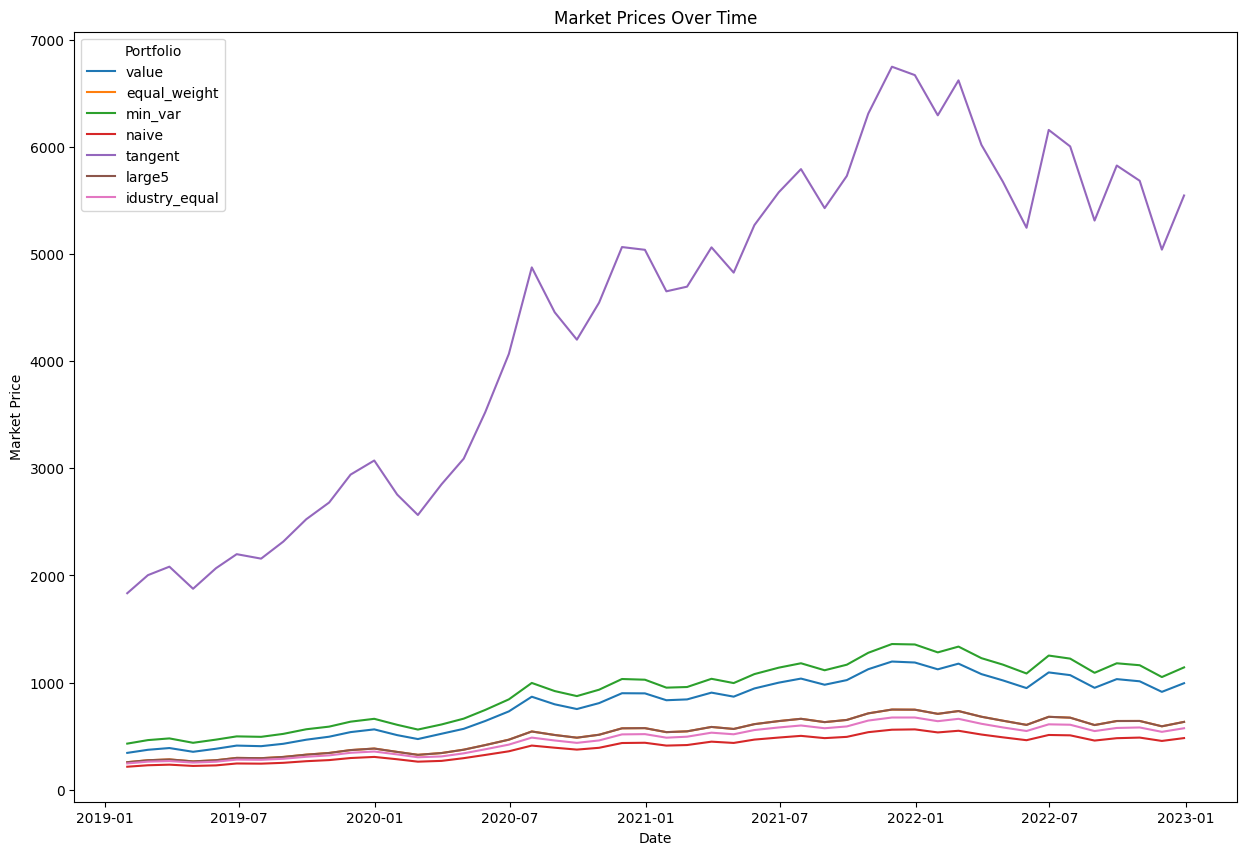

In [30]:
import matplotlib.pyplot as plt
output_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'output')
HP_DJ_Sto = Test_period
HP_DJ_Sto.shape # 175x32
weight.shape # 7* 30
market_prices = np.dot(weight,HP_DJ_Sto.iloc[:,1:-1].T)
# pd.DataFrame(market_prices).shape
mkt_P_df = pd.DataFrame(market_prices, index=weight.index, columns=HP_DJ_Sto['Date'])
mkt_P_bench_df = HP_DJ_Sto.iloc[:,-1].T
plt.figure(figsize=(15, 10))
for stock in mkt_P_df.index:
    plt.plot(mkt_P_df.columns, mkt_P_df.loc[stock,:], label=stock)

plt.title('Market Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Market Price')
plt.legend(title='Portfolio')
# plt.savefig(os.path.join(output_folder,'Market_Prices_Over_Time.png'))
plt.show()

In [472]:

# def save_data_to_pickle(data, pickle_name):
#     import pickle,os

#     pickle_name = pickle_name+'.pickle'
#     output_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'output')
#     print(output_folder)
#     # if not os.path.exists(output_folder):
#     #     os.makedirs(output_folder)
    
#     with open(os.path.join(output_folder, pickle_name),'wb') as file:
#         pickle.dump(data,file)

# save_data_to_pickle(weight, 'Part3_diff_strategy')
# save_data_to_pickle(BT_perform_df, 'Part3_BT_performance')
# save_data_to_pickle(third_fliter, 'Part3_fliter')
# save_data_to_pickle(test_perform_df, 'Part3_test_performance')

### imporove

use BT to determine the weight